#### Import modules

In [1]:
# Python 3.9.13, Conda 22.9.0

In [1]:
import pandas as pd # version 1.4.4
import numpy as np # version 1.21.5
import matplotlib.pyplot as plt
import imblearn # version 0.9.1
import sklearn #version 1.1.3
import xgboost # version 1.7.1
import matplotlib # version 3.5.2
import seaborn as sns # version 0.11.2

import itertools
 
from sklearn.linear_model import LogisticRegression ### Use a logistic regression but change the threshold ... This often solves the problem
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score,accuracy_score,f1_score,recall_score,roc_auc_score # F1 score will probably be the most important one
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier


from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [2]:
import warnings
warnings.filterwarnings("ignore") 

#### Not using neural networks because its not explainable.

#### Read in datasets

In [4]:
train = pd.read_csv(r"C:\Users\rodge\Downloads\Training_set.csv")
test = pd.read_csv(r"C:\Users\rodge\Downloads\Test_set.csv" )

#### sanity checks for features derived from other features
- codebook possible typo: in describing the variable "num_acc_30d_past_due_6_months" : Numer of accounts that are 30 or more days delinquent within last **62** months. There is no time dimension so we can't verify this with data. I think it should be 6 months.

In [5]:
train.columns

Index(['tot_balance', 'avg_bal_cards', 'credit_age', 'credit_age_good_account',
       'credit_card_age', 'num_acc_30d_past_due_12_months',
       'num_acc_30d_past_due_6_months', 'num_mortgage_currently_past_due',
       'tot_amount_currently_past_due', 'num_inq_12_month',
       'num_card_inq_24_month', 'num_card_12_month', 'num_auto_ 36_month',
       'uti_open_card', 'pct_over_50_uti', 'uti_max_credit_line',
       'pct_card_over_50_uti', 'ind_XYZ', 'rep_income', 'rep_education',
       'Def_ind'],
      dtype='object')

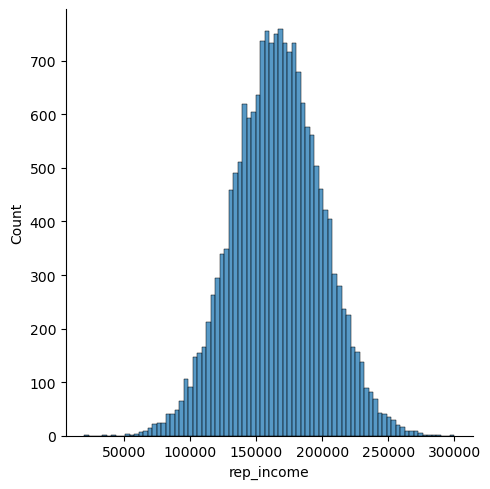

In [6]:
sns.displot(train , x=train['rep_income'])

In [7]:
train[train.tot_balance<train.avg_bal_cards]

,tot_balance,avg_bal_cards,credit_age,credit_age_good_account,credit_card_age,num_acc_30d_past_due_12_months,num_acc_30d_past_due_6_months,num_mortgage_currently_past_due,tot_amount_currently_past_due,num_inq_12_month,...,num_card_12_month,num_auto_ 36_month,uti_open_card,pct_over_50_uti,uti_max_credit_line,pct_card_over_50_uti,ind_XYZ,rep_income,rep_education,Def_ind
6522,0.0,4736.516393,377,165,340,0,0,0,0.0,0,...,0,0,0.45004,0.435943,0.311827,0.53592,0,229338.8875,college,0


In [8]:
test[test.tot_balance<test.avg_bal_cards]

,tot_balance,avg_bal_cards,credit_age,credit_age_good_account,credit_card_age,num_acc_30d_past_due_12_months,num_acc_30d_past_due_6_months,num_mortgage_currently_past_due,tot_amount_currently_past_due,num_inq_12_month,...,num_card_12_month,num_auto_ 36_month,uti_open_card,pct_over_50_uti,uti_max_credit_line,pct_card_over_50_uti,ind_XYZ,rep_income,rep_education,Def_ind
328,5640.042349,7761.592085,321,210,349,3,1,0,22303.65125,0,...,0,0,0.635615,0.674418,0.584614,NaN,0,NaN,high_school,0
1013,6292.924740,7758.972249,201,115,217,0,0,0,0.00000,0,...,0,0,0.628820,0.650793,0.829899,0.681068,0,137004.0215,other,1


In [9]:
train[train.num_acc_30d_past_due_12_months<train.num_acc_30d_past_due_6_months]

,tot_balance,avg_bal_cards,credit_age,credit_age_good_account,credit_card_age,num_acc_30d_past_due_12_months,num_acc_30d_past_due_6_months,num_mortgage_currently_past_due,tot_amount_currently_past_due,num_inq_12_month,...,num_card_12_month,num_auto_ 36_month,uti_open_card,pct_over_50_uti,uti_max_credit_line,pct_card_over_50_uti,ind_XYZ,rep_income,rep_education,Def_ind


In [10]:
test[test.num_acc_30d_past_due_12_months<test.num_acc_30d_past_due_6_months]

,tot_balance,avg_bal_cards,credit_age,credit_age_good_account,credit_card_age,num_acc_30d_past_due_12_months,num_acc_30d_past_due_6_months,num_mortgage_currently_past_due,tot_amount_currently_past_due,num_inq_12_month,...,num_card_12_month,num_auto_ 36_month,uti_open_card,pct_over_50_uti,uti_max_credit_line,pct_card_over_50_uti,ind_XYZ,rep_income,rep_education,Def_ind
1542,84522.60620,15447.465970,284,171,287,0,1,0,0.0,0,...,1,0,0.591361,0.548500,0.535585,0.570758,0,95323.85276,high_school,1
2193,59489.95435,10065.615770,370,164,312,0,1,0,0.0,2,...,0,1,0.247507,0.256402,0.353352,0.315818,0,175596.03160,college,0
2769,88602.71567,9080.218509,257,187,267,0,1,0,0.0,0,...,1,0,0.423375,0.500768,0.521541,0.525957,1,NaN,high_school,0
3520,105718.14380,15968.912340,345,191,298,0,1,0,0.0,0,...,0,0,0.528708,0.526750,0.691192,0.733193,0,163694.66810,high_school,0
4381,60421.99325,12419.815880,215,129,282,0,1,0,0.0,0,...,1,0,0.698131,0.494072,0.723856,0.743805,0,119081.46460,college,0


#### Group by's

In [11]:
train.groupby(["ind_XYZ"])["Def_ind"].value_counts(normalize=True) # people who dont have accounts with XYZ have a higher default rate

ind_XYZ  Def_ind
0        0          0.8926
         1          0.1074
1        0          0.9222
         1          0.0778
Name: Def_ind, dtype: float64

In [12]:
train.groupby(["Def_ind"])["rep_education"].value_counts(normalize=True) 

Def_ind  rep_education
0        college          0.608923
         high_school      0.261070
         graduate         0.122729
         other            0.007278
1        college          0.588500
         high_school      0.307500
         graduate         0.098500
         other            0.005500
Name: rep_education, dtype: float64

In [13]:
train.Def_ind.value_counts(normalize = True)

0    0.9
1    0.1
Name: Def_ind, dtype: float64

In [14]:
train.groupby("rep_education")["rep_education"].count()

rep_education
college        12137
graduate        2406
high_school     5314
other            142
Name: rep_education, dtype: int64

#### Analyzing datasets

In [15]:
def data_summary(df:pd.DataFrame):
    """Summarize the dataset: dimensions, columns present, summary statistics, data types
    class balance, rows and columns with Nans
    """
    print(f"Data Dimensions, rows: {df.shape[0]}, columns:{df.shape[1]}")
    print()
    print("Columns :\n",df.columns)
    print()
    print("Summary Statistics :\n",pd.DataFrame(df.describe()))
    print()
    print("Data Types:\n ",df.dtypes)
    print("columns with nans :\n",df.columns[df.isna().any()].tolist())
    print("percentage of rows with nans :\n", len(df[df.isna().any(axis=1)])/len(df))
    print("class balance :\n", df["Def_ind"].value_counts(normalize = True))
    

#### Call function on the testing and training set

In [16]:
#data_summary(train)
#data_summary(test)

In [17]:
all_data = train.append(test )

In [18]:
test[test.isna().any(axis=1)]

,tot_balance,avg_bal_cards,credit_age,credit_age_good_account,credit_card_age,num_acc_30d_past_due_12_months,num_acc_30d_past_due_6_months,num_mortgage_currently_past_due,tot_amount_currently_past_due,num_inq_12_month,...,num_card_12_month,num_auto_ 36_month,uti_open_card,pct_over_50_uti,uti_max_credit_line,pct_card_over_50_uti,ind_XYZ,rep_income,rep_education,Def_ind
6,119974.74610,17007.072350,96,105,90,0,0,0,0.000000,8,...,0,0,0.607728,0.513052,0.741299,NaN,0,126797.7154,college,0
11,68478.00731,8735.047285,346,221,297,0,0,0,0.000000,2,...,0,0,0.497713,0.456977,0.341593,0.491084,0,NaN,college,0
14,103887.71060,12671.397800,345,180,308,0,0,0,0.000000,0,...,0,0,0.435109,0.403840,0.406685,0.559913,1,NaN,graduate,0
15,115446.97190,13213.717870,302,220,333,0,0,0,0.000000,0,...,0,0,0.363788,0.346888,0.273747,NaN,0,NaN,college,0
20,97563.66343,12759.657960,316,214,312,0,0,0,0.000000,0,...,0,0,0.514029,0.475814,0.426018,NaN,0,192338.1624,high_school,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4983,104918.44800,14202.263590,395,170,393,0,0,0,0.000000,1,...,0,1,0.235251,0.394718,0.296827,0.230202,1,NaN,college,0
4989,102341.37510,10645.684360,386,178,455,0,0,0,0.000000,0,...,0,0,0.431124,0.519556,0.588845,0.494612,0,NaN,college,0
4990,55983.02723,8841.166160,392,179,444,3,1,1,22000.250450,0,...,0,0,0.399550,0.430438,0.442103,NaN,1,176655.2329,college,0
4994,119033.54390,15142.315590,340,163,313,0,0,0,0.000000,0,...,0,0,0.381293,0.430687,0.480817,NaN,0,128562.3560,college,0


#### Generate table of summary statistics

In [19]:
all_data.describe().T.to_excel(r"Downloads\sum_stat.xlsx") ### this is the summary statistics table in the technical report.

#### correlation :useful incase we were in a regression setting.

In [20]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(all_data.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

-Training set
   - Data has 20000 rows and 21 columns
   - 3 columns have Nan values, about 16% of the rows have a Nan
   - Class balance: 10% have defaulted, 90% have not defaulted. This is an imbalanced dataset. We will need to think about how we handle this.

-Testing set
 - 5000 rows, 21 columns as expected.
 - 3 columns have nans, about 17% of the rows have nan values
 - Same class imbalance as the training set.

### Modelling

- Before we do anything else we need to figure out how to handle the Nan values and the "rep_education" text column. The algorithms will throw an error with a str datatype
- As a first pass, we will drop all rows with nan values
- At this point we are also not creating any features yet. We implement a quick and dirty solution and the we iteratively improve it.

#### Sparsity?

##### How sparse is the data?  Could be problemamtic with bigger matrices

In [21]:
print('columns')
print(train[train == 0].count(axis=0)/len(train.index))

columns
tot_balance                        0.00005
avg_bal_cards                      0.00005
credit_age                         0.00005
credit_age_good_account            0.00005
credit_card_age                    0.00005
num_acc_30d_past_due_12_months     0.88070
num_acc_30d_past_due_6_months      0.97145
num_mortgage_currently_past_due    0.97000
tot_amount_currently_past_due      0.92995
num_inq_12_month                   0.70215
num_card_inq_24_month              0.65965
num_card_12_month                  0.74615
num_auto_ 36_month                 0.83830
uti_open_card                      0.00005
pct_over_50_uti                    0.00005
uti_max_credit_line                0.00005
pct_card_over_50_uti               0.00005
ind_XYZ                            0.75000
rep_income                         0.00000
rep_education                      0.00000
Def_ind                            0.90000
dtype: float64


In [22]:
print('columns')
print(test[test == 0].count(axis=0)/len(test.index))

columns
tot_balance                        0.0002
avg_bal_cards                      0.0002
credit_age                         0.0002
credit_age_good_account            0.0002
credit_card_age                    0.0002
num_acc_30d_past_due_12_months     0.7892
num_acc_30d_past_due_6_months      0.9348
num_mortgage_currently_past_due    0.9700
tot_amount_currently_past_due      0.7632
num_inq_12_month                   0.6426
num_card_inq_24_month              0.5580
num_card_12_month                  0.7476
num_auto_ 36_month                 0.8286
uti_open_card                      0.0002
pct_over_50_uti                    0.0002
uti_max_credit_line                0.0002
pct_card_over_50_uti               0.0002
ind_XYZ                            0.7500
rep_income                         0.0000
rep_education                      0.0000
Def_ind                            0.9000
dtype: float64


#### Fill in all nans with mode, mode, median as a first pass and One Hot Encode categorical text feature ("rep_education")

In [23]:
cols = ['pct_card_over_50_uti', 'rep_income', 'rep_education']
test[cols]=test[cols].fillna(test.mode().iloc[0])
train[cols]=train[cols].fillna(train.mode().iloc[0])

#### training set

In [24]:
enc = OneHotEncoder(handle_unknown="ignore")
encode_df_train = pd.DataFrame(enc.fit_transform(train[['rep_education']]).toarray())
# rename columns to original columns.

cat_column_names = [item for items in enc.categories_ for item in items]
encode_df_train.columns = cat_column_names

#### testing set

In [25]:
enc = OneHotEncoder(handle_unknown="ignore")
encode_df_test = pd.DataFrame(enc.fit_transform(test[['rep_education']]).toarray())
# rename columns to original columns.

cat_column_names = [item for items in enc.categories_ for item in items]
encode_df_test.columns = cat_column_names

#### Add back encoded columns \& assign to self

In [26]:
train = pd.concat([train,encode_df_train], axis = 1)

In [27]:
test = pd.concat([test,encode_df_test], axis = 1)

#### drop text column

In [28]:
train.drop(columns = "rep_education", inplace = True)
test.drop(columns = "rep_education", inplace = True)

#### Separate features and labels

In [29]:
train_X = train.loc[:, train.columns != "Def_ind"]
test_X = test.loc[:, test.columns != "Def_ind"]
train_y = train["Def_ind"]
test_y = test["Def_ind"]

#### compare models quickly to select which one to use in addition to Logistic regression

In [30]:
def train_compare_models(train_X: pd.DataFrame, train_y:pd.Series, test_X:pd.DataFrame, test_y:pd.Series)->pd. DataFrame:
    """ Function to train and compare multiple models quickly then improve
    :param train_x: training set variables (features)
    :param train_y: classes/labels for the training set
    :param test_x: test set variables (features)
    :param test_y: classes/labels for the test set
    """
    
    dataframes = []
    results = []
    algorithms = []
    
    models = [('LR', LogisticRegression()), ('RF', RandomForestClassifier()), ('XGB', XGBClassifier())]
    
    scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    target_names = ["did_not_default","defaulted"]
    
    for algorithm, model in models:
        kfold = model_selection.KFold(n_splits = 5, shuffle = True, random_state = 5)
        cv_results = model_selection.cross_validate(model, train_X, train_y, cv = kfold,  scoring =  scoring)
        clf = model.fit(train_X, train_y)
        pred_y = clf.predict(test_X)
        print(algorithm)
        print(classification_report(test_y,pred_y, target_names=target_names))
              
        results.append(cv_results)
        algorithms.append(algorithms)
              
        results_df = pd.DataFrame(cv_results)
        results_df['model'] = algorithm
        dataframes.append(results_df)
              
    all_results_df = pd.concat(dataframes, ignore_index=True)
    
    return all_results_df

#### mode imputed data results

In [31]:
data = train_compare_models(train_X, train_y, test_X, test_y)

LR
                 precision    recall  f1-score   support

did_not_default       0.92      0.95      0.93      4500
      defaulted       0.35      0.22      0.27       500

       accuracy                           0.88      5000
      macro avg       0.63      0.59      0.60      5000
   weighted avg       0.86      0.88      0.87      5000

RF
                 precision    recall  f1-score   support

did_not_default       0.94      0.96      0.95      4500
      defaulted       0.54      0.41      0.47       500

       accuracy                           0.91      5000
      macro avg       0.74      0.68      0.71      5000
   weighted avg       0.90      0.91      0.90      5000

XGB
                 precision    recall  f1-score   support

did_not_default       0.94      0.96      0.95      4500
      defaulted       0.53      0.45      0.49       500

       accuracy                           0.91      5000
      macro avg       0.74      0.70      0.72      5000
   weighted a

## let's try another configuration where we drop all the nan's

In [32]:
train = pd.read_csv(r"C:\Users\rodge\Downloads\Training_set.csv")
test = pd.read_csv(r"C:\Users\rodge\Downloads\Test_set.csv" )

In [33]:
train_no_nan = train.dropna().reset_index()
test_no_nan = test.dropna().reset_index()

#### one hot encode

In [34]:
train_no_nan.drop(columns = "index", inplace =True)
test_no_nan.drop(columns = "index", inplace =True)

In [35]:
enc = OneHotEncoder(handle_unknown="ignore")
encode_df_train = pd.DataFrame(enc.fit_transform(train_no_nan[['rep_education']]).toarray())
# rename columns to original columns.

cat_column_names = [item for items in enc.categories_ for item in items]
encode_df_train.columns = cat_column_names

In [36]:
enc = OneHotEncoder(handle_unknown="ignore")
encode_df_test = pd.DataFrame(enc.fit_transform(test_no_nan[['rep_education']]).toarray())
# rename columns to original columns.

cat_column_names = [item for items in enc.categories_ for item in items]
encode_df_test.columns = cat_column_names

In [37]:
train_no_nan.drop(columns = "rep_education", inplace = True)
test_no_nan.drop(columns = "rep_education", inplace = True)

In [38]:
print(len(train_no_nan), len(encode_df_train),len(test_no_nan),len(encode_df_test))

16653 16653 4133 4133


In [39]:
training_set = pd.concat([train_no_nan,encode_df_train], axis = 1)
testing_set = pd.concat([test_no_nan,encode_df_test], axis = 1)

In [40]:
train_X = training_set.loc[:, training_set.columns != "Def_ind"]
test_X = testing_set.loc[:, testing_set.columns != "Def_ind"]
train_y = training_set["Def_ind"]
test_y = testing_set["Def_ind"]

In [41]:
def train_compare_models(train_X: pd.DataFrame, train_y:pd.Series, test_X:pd.DataFrame, test_y:pd.Series)->pd. DataFrame:
    """ Function to train and compare multiple models quickly then improve
    :param train_x: training set variables (features)
    :param train_y: classes/labels for the training set
    :param test_x: test set variables (features)
    :param test_y: classes/labels for the test set
    """
    
    dataframes = []
    results = []
    algorithms = []
    
    models = [('LR', LogisticRegression()), ('RF', RandomForestClassifier()), ('XGB', XGBClassifier())]
    
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
    target_names = ["defaulted", "did_not_default"]
    
    for algorithm, model in models:
        kfold = model_selection.KFold(n_splits = 5, shuffle = True, random_state = 5)
        cv_results = model_selection.cross_validate(model, train_X, train_y, cv = kfold,  scoring =  scoring)
        clf = model.fit(train_X, train_y)
        pred_y = clf.predict(test_X)
        print(algorithm)
        print(classification_report(test_y,pred_y, target_names=target_names))
              
        results.append(cv_results)
        algorithms.append(algorithms)
              
        results_df = pd.DataFrame(cv_results)
        results_df['model'] = algorithm
        dataframes.append(results_df)
              
    all_results_df = pd.concat(dataframes, ignore_index=True)
    
    return all_results_df

In [42]:
data_no_nan = train_compare_models(train_X, train_y, test_X, test_y)

LR
                 precision    recall  f1-score   support

      defaulted       0.92      0.95      0.94      3728
did_not_default       0.35      0.23      0.28       405

       accuracy                           0.88      4133
      macro avg       0.64      0.59      0.61      4133
   weighted avg       0.86      0.88      0.87      4133

RF
                 precision    recall  f1-score   support

      defaulted       0.94      0.97      0.95      3728
did_not_default       0.56      0.39      0.46       405

       accuracy                           0.91      4133
      macro avg       0.75      0.68      0.71      4133
   weighted avg       0.90      0.91      0.90      4133

XGB
                 precision    recall  f1-score   support

      defaulted       0.94      0.95      0.95      3728
did_not_default       0.50      0.43      0.46       405

       accuracy                           0.90      4133
      macro avg       0.72      0.69      0.71      4133
   weighted a

#### The classification report reveals two things.
 - The performance of the algorithms on the minority class is subpar
 - And surprisingly the Random forest outperforms the XGBoost and has a slower training time

#### Let's tweak the parameters of the Logistic regression and the random forest and check if we can improve their performance

#### RF hyperparameters

#### We will use a parameter grid to tune a hyper parameters of the random forest

In [43]:
train_X = training_set.loc[:, training_set.columns != "Def_ind"]
test_X = testing_set.loc[:, testing_set.columns != "Def_ind"]
train_y = training_set["Def_ind"]
test_y = testing_set["Def_ind"]

In [44]:
param_grid = {
    "n_estimators":[100,500,1000],
    "max_depth":[10, 50, 100],
    "max_features":[6,14,16,24 ]
}

In [45]:
rf = RandomForestClassifier()

In [46]:
rf_optimized = GridSearchCV(estimator=rf,
                            param_grid=param_grid,
                            cv=3,
                            n_jobs=-1,
                            verbose=2)

In [47]:
rf_optimized.fit(train_X, train_y)
rf_optimized.best_estimator_ ### best model max_depth = 100, max_features = 14, n_estimators = 1000

Fitting 3 folds for each of 36 candidates, totalling 108 fits


RandomForestClassifier(max_depth=50, max_features=16, n_estimators=500)

#### Lets see feature importances for the best model

In [48]:
rf_best = rf_optimized.best_estimator_

In [49]:
col_names = train_X.columns

In [50]:
f = pd.DataFrame(rf_best.feature_importances_, index=col_names, columns=["feature_importance"])
f.sort_values("feature_importance", ascending=False)

,feature_importance
avg_bal_cards,0.175431
uti_open_card,0.108155
pct_over_50_uti,0.070662
uti_max_credit_line,0.069265
pct_card_over_50_uti,0.066760
num_acc_30d_past_due_12_months,0.066015
rep_income,0.063069
tot_balance,0.060679
credit_age,0.059871
credit_card_age,0.057205


#### fitting model with best estimator above.

In [51]:
rf_best = RandomForestClassifier(max_depth=100, max_features=14, n_estimators=1000)

In [52]:
model = rf_best.fit(train_X, train_y)

In [53]:
pred_y = model.predict(test_X)

In [54]:
target_names = ["did_not_default","defaulted"]
print("RF")
print(classification_report(test_y,pred_y, target_names=target_names))

RF
                 precision    recall  f1-score   support

did_not_default       0.94      0.96      0.95      3728
      defaulted       0.53      0.44      0.48       405

       accuracy                           0.91      4133
      macro avg       0.73      0.70      0.71      4133
   weighted avg       0.90      0.91      0.90      4133



In [55]:
cm = confusion_matrix(test_y,pred_y, labels=[0,1])

In [56]:
fig = plt.figure()
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax,cmap='Greens');  #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([ "did_not_default","defaulted"]); ax.yaxis.set_ticklabels([ "did_not_default","defaulted"]);
fig.savefig('cm_rf.png')

In [57]:
roc_auc_score(test_y,pred_y)

0.6981597387802682

#### Logistic regression hyperparameters

In [58]:
pipe = Pipeline([('classifier' ,  LogisticRegression())])

In [59]:
param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']}]

In [60]:
lr = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)


In [61]:
lr.fit(train_X, train_y)
lr.best_estimator_ 

Fitting 5 folds for each of 40 candidates, totalling 200 fits


Pipeline(steps=[('classifier',
                 LogisticRegression(C=0.08858667904100823, penalty='l1',
                                    solver='liblinear'))])

In [62]:
lr_best = LogisticRegression(C=0.08858667904100823, penalty='l1', solver='liblinear')

In [63]:
lr_best = lr_best.fit(train_X, train_y)

#### We make considerations here for the use case. Because this is a client facing application, we want to reject applications if and only iff there is evidence that the client will default. We achieve this by setting an abitrarily high cutoff for the prediction. We will use the predict_proba instead of predict for this case

In [64]:
set_threshold = 0.5

In [65]:
prediction = np.where(lr_best.predict_proba(test_X)[:,1] > set_threshold, 1, 0)

In [66]:
pd.DataFrame(data=[accuracy_score(test_y, prediction), recall_score(test_y, prediction),
                   precision_score(test_y, prediction), roc_auc_score(test_y, prediction), f1_score(test_y, prediction)], 
             index=["accuracy", "recall", "precision", "roc_auc_score", "f1_score"], columns =["metrics"])

,metrics
accuracy,0.902008
recall,0.279012
precision,0.500000
roc_auc_score,0.624351
f1_score,0.358162


In [67]:
print("LR")
print(classification_report(test_y,prediction, target_names=target_names)) # threshold 0.9

LR
                 precision    recall  f1-score   support

did_not_default       0.93      0.97      0.95      3728
      defaulted       0.50      0.28      0.36       405

       accuracy                           0.90      4133
      macro avg       0.71      0.62      0.65      4133
   weighted avg       0.88      0.90      0.89      4133



In [68]:
set_threshold = 0.5 # with the same threshold

In [69]:
prediction = np.where(lr_best.predict_proba(test_X)[:,1] > set_threshold, 1, 0)

In [70]:
pd.DataFrame(data=[accuracy_score(test_y, prediction), recall_score(test_y, prediction),
                   precision_score(test_y, prediction), roc_auc_score(test_y, prediction), f1_score(test_y, prediction)], 
             index=["accuracy", "recall", "precision", "roc_auc_score", "f1_score"], columns =["metrics"])

,metrics
accuracy,0.902008
recall,0.279012
precision,0.500000
roc_auc_score,0.624351
f1_score,0.358162


In [71]:
print(classification_report(test_y,prediction, target_names=target_names))

                 precision    recall  f1-score   support

did_not_default       0.93      0.97      0.95      3728
      defaulted       0.50      0.28      0.36       405

       accuracy                           0.90      4133
      macro avg       0.71      0.62      0.65      4133
   weighted avg       0.88      0.90      0.89      4133



In [72]:
cm = confusion_matrix(test_y,prediction, labels=[0,1])

In [73]:
fig = plt.figure()
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax,cmap='Greens');  #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([ "did_not_default","defaulted"]); ax.yaxis.set_ticklabels([ "did_not_default","defaulted"]);
fig.savefig('cm_lr.png')

#### The logistic regression does not outperform the random forest on defaulters using the f1_score

In [74]:
feature_importance = abs(lr_best.coef_[0])

In [75]:
np.sort(feature_importance)

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 7.20962216e-07, 3.12580780e-06,
       4.61914098e-05, 1.27030361e-04, 1.32064698e-04, 1.08365797e-03,
       3.98347520e-03, 2.33223115e-02, 6.56421366e-02, 8.58894745e-02,
       1.12541923e-01, 1.53847952e-01, 2.15561970e-01, 2.42647496e-01,
       3.07330581e-01, 9.17680257e-01, 4.71441466e+00])

In [76]:
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

In [77]:
sorted_idx

array([22, 20, 19, 16, 15, 12, 18,  0,  8,  1,  3,  4,  2, 10,  7, 21, 11,
       14,  6, 17,  9,  5, 13], dtype=int64)

In [78]:
np.array(train_X.columns)[sorted_idx]

array(['other', 'graduate', 'college', 'pct_card_over_50_uti',
       'uti_max_credit_line', 'num_auto_ 36_month', 'rep_income',
       'tot_balance', 'tot_amount_currently_past_due', 'avg_bal_cards',
       'credit_age_good_account', 'credit_card_age', 'credit_age',
       'num_card_inq_24_month', 'num_mortgage_currently_past_due',
       'high_school', 'num_card_12_month', 'pct_over_50_uti',
       'num_acc_30d_past_due_6_months', 'ind_XYZ', 'num_inq_12_month',
       'num_acc_30d_past_due_12_months', 'uti_open_card'], dtype=object)

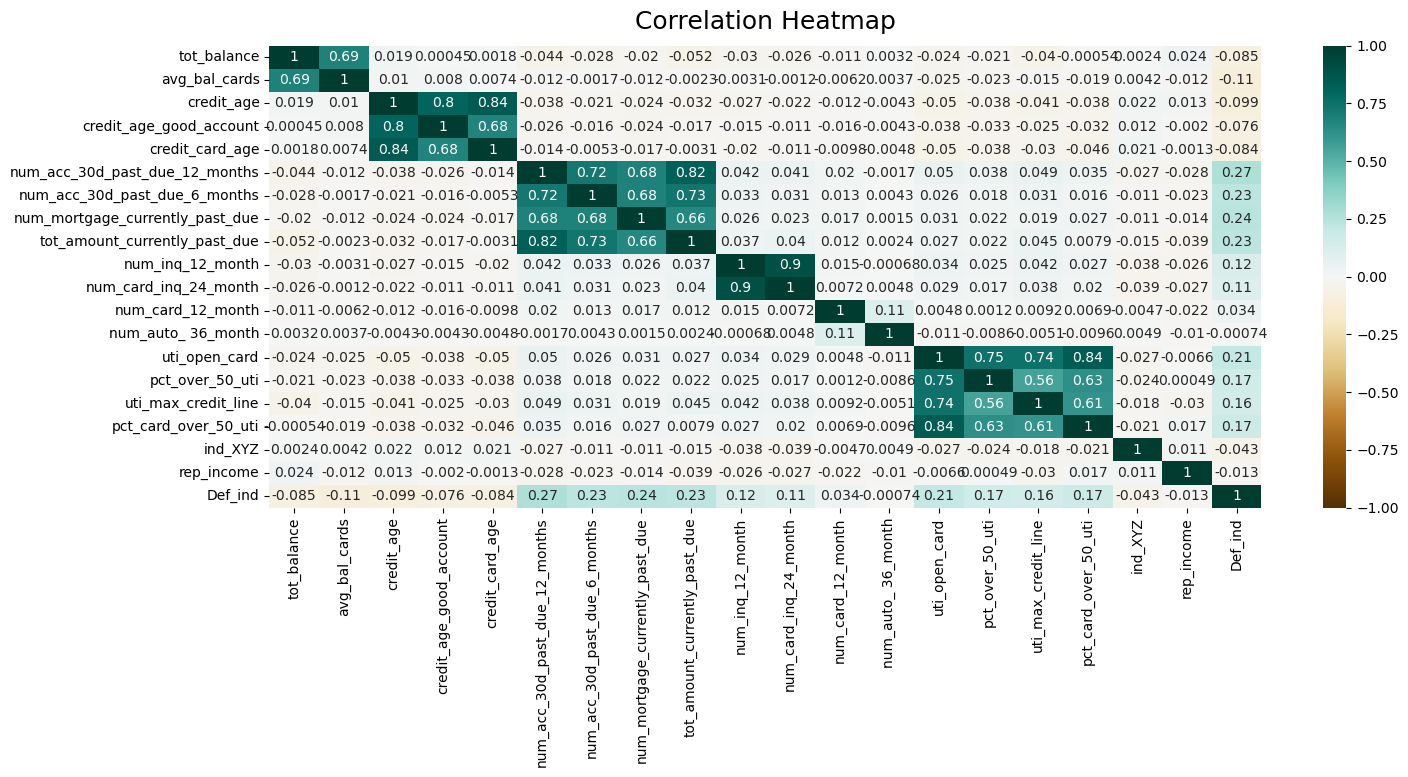

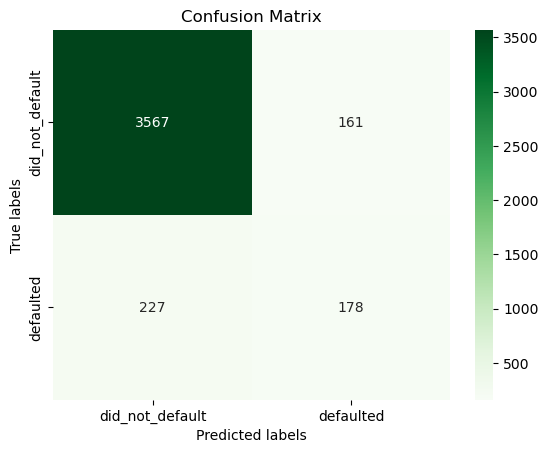

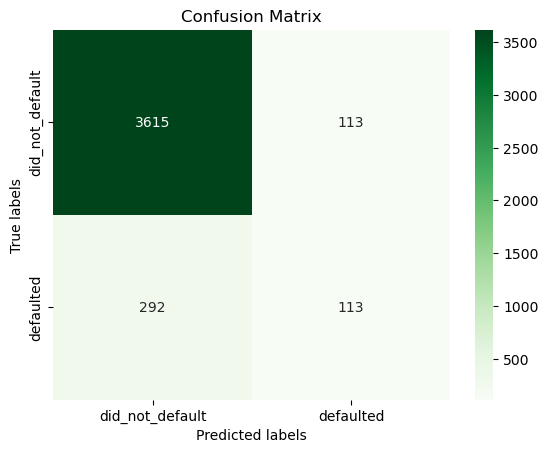

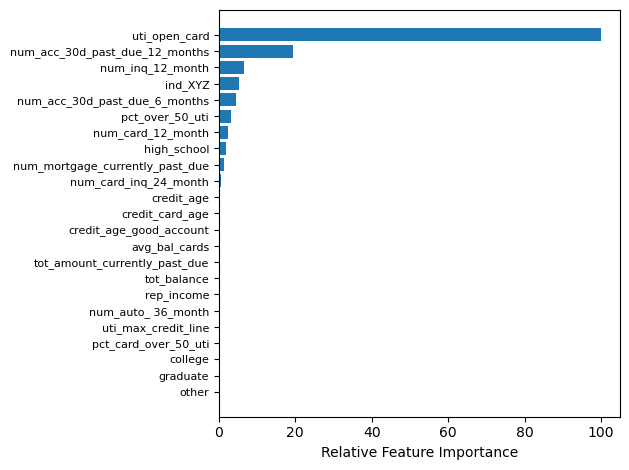

In [79]:
featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(train_X.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()

In [2]:
#samplecode